In [1]:
import gradoptics as optics
import matplotlib.pyplot as plt
import torch

Matplotlib created a temporary config/cache directory at /var/folders/tg/2_q32n3x5q75j4ytd6n3kmvh0000gp/T/matplotlib-m3yao9gg because the default path (/Users/stanford/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Creating a scene, and producing an image

## Creating a scene

In [2]:
f = 0.05 # focal length (meters)
m = 0.15 # magnification

image_pof = -f * (1 + m)
object_pof = f * (1 + m) / m

# Creating a (thin) lens
lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)

## Creating a sensor
sensor = optics.Sensor(resolution=(9600, 9600), pixel_size=(3.76e-6, 3.76e-6), 
                       position=(image_pof, 0, 0), poisson_noise_mean=2, 
                       quantum_efficiency=0.8)

# Creating an Atom Cloud (which is a distribution)
atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[object_pof, 0., 0.], phi=0.1)

# Wrapping the atom cloud to a light source, which will allow to sample photons
light_source = optics.LightSourceFromDistribution(atom_cloud)

# Creating a scene
scene = optics.Scene(light_source)
scene.add_object(lens) # Adding the lens to the scene
scene.add_object(sensor) # Adding the sensor to the scene

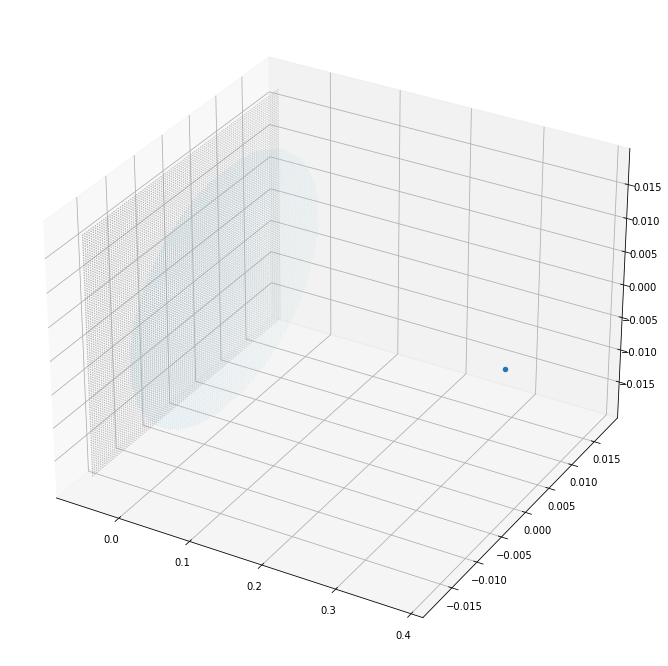

In [3]:
# Vizualizing the scene
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
scene.plot(ax)

## Producing an image

In [4]:
# Let us use the cpu for simplicity (everything will be much faster on GPU)
device = 'cpu'

# Let us start by sampling 10M rays (i.e. 10M photons) from the light source
rays = light_source.sample_rays(10_000_000, device=device)

# Computing the time at which the rays will intersect the lens
t = lens.get_ray_intersection(rays)
# Some rays do not intersect the lens, throw them away
mask = ~torch.isnan(t)
# Computing the rays refracted by the lens
refracted_rays, _ = lens.intersect(rays[mask], t[mask])

# Repeating the operations on the sensor for the refracted rays
t = sensor.get_ray_intersection(refracted_rays)
mask = ~torch.isnan(t)
sensor.intersect(refracted_rays[mask], t[mask])

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()

/Users/stanford/Library/Python/3.8/lib/python/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


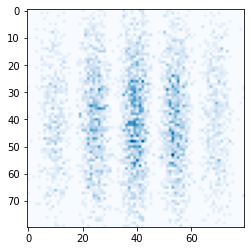

In [5]:
c = (4800, 4800)
w = 40
plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')

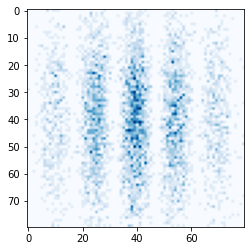

In [6]:
# Alternatively, the built-in function forward_ray_tracing can be used
rays = light_source.sample_rays(10_000_000, device=device)
optics.forward_ray_tracing(rays, scene, max_iterations=2)

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()

plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')